# Image Capioning 기본 구조: CNN + RNN

In [13]:
# 이미지 전처리
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

image = Image.open('./test.jpg').convert('RGB')
image_tensor = transform(image).unsqueeze(0)

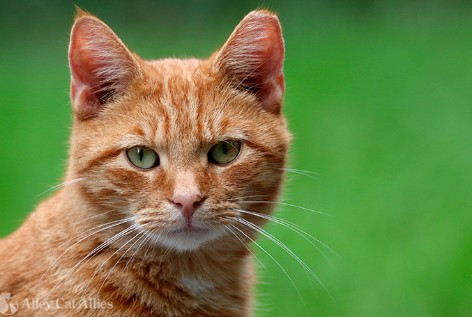

In [14]:
image

In [15]:
# 단어 사전
vocab = {
    0: "<pad>",
    1: "<start>",
    2: "<end>",
    3: "a",
    4: "cat",
    5: "is",
    6: "looking",
    7: "at",
    8: "the",
    9: "lens",
    10: "on",
    11: "the",
    12: "grass"
}

In [21]:
# VGG 모델 로드 (이미지로부터 특징 추출)

from torchvision.models import vgg16
import torch

vgg = vgg16(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False

with torch.no_grad():
    features = vgg(image_tensor)
    features = features.view(features.size(0), -1).unsqueeze(1)

In [22]:
# 단어사전을 토대로 학습 입/출력 데이터 생성
caption = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2]
input_seq = torch.tensor([caption[:-1]])    # end 토큰빼고
target_seq = torch.tensor([caption[1:]])    # start 토큰빼고

In [23]:
# RNN 계열 Caption 생성 모델 생성 (이미지 특징 + 이전 단어 -> 다음 단어 예측)
# 다만 학습을 하더라고 단어사전(미리 지정한) 안에서만 뱉어주기에 항상 잘 될거임

import torch.nn as nn

class CaptionGenerator(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim, vocab_size):
        super(CaptionGenerator, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, vocab_size)
        self.init_linear = nn.Linear(feature_dim, embed_dim)


    def forward(self, features, captions):
        embedded_features = self.init_linear(features)
        embeds = self.embed(captions)
        inputs = torch.cat((embedded_features, embeds), dim=1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.decoder(hiddens)
        return outputs[:, 1:, :]    # 첫 timestep은 제외


In [24]:
import torch.optim as optim

# 모델 학습
model = CaptionGenerator(feature_dim=25088, embed_dim=512, hidden_dim=512, vocab_size=len(vocab))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()

    optimizer.zero_grad()

    outputs = model(features, input_seq)
    loss = criterion(outputs.squeeze(0), target_seq.squeeze(0))
    loss.backward()
    optimizer.step()

In [25]:
# 모델 예측

model.eval()
with torch.no_grad():
    generated = []
    input_word = torch.tensor([[1]])

    embed_feat = model.init_linear(features)
    hidden = None

    for _ in range(10):
        embed_input = model.embed(input_word)
        lstm_input = torch.cat((embed_feat, embed_input), dim=1) if len(generated) == 0 else embed_input
        out, hidden = model.lstm(lstm_input, hidden)
        pred = model.decoder(out[:, -1, :])
        pred_id = pred.argmax(dim=-1).item()

        if pred_id == 2:
            break

        generated.append(pred_id)
        input_word = torch.tensor([[pred_id]])
        embed_feat = None

    sentence = " ".join([vocab[idx] for idx in generated])

    print("생성된 캡션", sentence)


생성된 캡션 a cat is looking at the lens on the grass
